# Market Data Visulaizer

### Step 0: Imports

In [17]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interact

# make plots a bit larger
plt.rcParams["figure.figsize"] = (11, 4)

## Part 1: Loading Data

### Step 1.1: Data Location & Available Files

In [2]:
# Output .csv files in data/raw/..

raw_dir = Path("../data/raw")
raw_dir.mkdir(parents=True, exist_ok=True)  # ensure folder exists
csv_files = sorted([p for p in raw_dir.glob("*.csv")])
if not csv_files:
    print("No CSV files found in ../data/raw yet. Save one with fetch_data_yf.py first.")
csv_files[:5]  # preview list

[PosixPath('../data/raw/aapl_1d_2010-01-01_2025-08-16_yf.csv'),
 PosixPath('../data/raw/spy_1d_2020-01-01_2025-08-16_yf.csv')]

### Step 1.2: Choose & Load Dataset

In [5]:
# choose the file to explore (interactive but simple)
symbol = input("symbol used in filename (e.g., btc_usd or aapl): ").strip().lower()
interval = input("interval used in filename (e.g., 1d, 1wk, 1h): ").strip()

maybe_start = input("start date used in filename (YYYY-MM-DD) or blank: ").strip()
maybe_end   = input("end date used in filename (YYYY-MM-DD) or blank: ").strip()

raw_dir = Path("../data/raw")
file_path = raw_dir / f"{symbol}_{interval}_{maybe_start}_{maybe_end}_yf.csv"

print("loading:", file_path)

# parse timestamps on load
df = pd.read_csv(file_path, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
df.head()

symbol used in filename (e.g., btc_usd or aapl):  aapl
interval used in filename (e.g., 1d, 1wk, 1h):  1d
start date used in filename (YYYY-MM-DD) or blank:  2010-01-01
end date used in filename (YYYY-MM-DD) or blank:  2025-08-16


loading: ../data/raw/aapl_1d_2010-01-01_2025-08-16_yf.csv


,timestamp,open,high,low,close,volume
0,2010-01-04 00:00:00+00:00,7.622500,7.660714,7.585000,6.424605,493729600
1,2010-01-05 00:00:00+00:00,7.664286,7.699643,7.616071,6.435713,601904800
2,2010-01-06 00:00:00+00:00,7.656429,7.686786,7.526786,6.333345,552160000
3,2010-01-07 00:00:00+00:00,7.562500,7.571429,7.466071,6.321635,477131200
4,2010-01-08 00:00:00+00:00,7.510714,7.571429,7.466429,6.363664,447610800


## Part 2: Initial EDA

### Step 2.1: Sanity Check

In [6]:
# Sanity check

print("rows:", len(df))
print("range:", df["timestamp"].min().date(), "→", df["timestamp"].max().date())
print("columns:", list(df.columns))

# missing values check
print("\nmissing values per column:")
print(df.isna().sum())

rows: 3929
range: 2010-01-04 → 2025-08-15
columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume']

missing values per column:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64


### Step 2.2: Closing Price Chart

The closing price is the last traded price of the asset for each interval (e.g., daily close).
Plotting it over time gives an immediate sense of:

	• Whether the asset is trending upward, downward, or moving sideways.
	• Periods of sharp rises or crashes (e.g., during market events).
	• Long-term growth patterns versus short-term fluctuations.

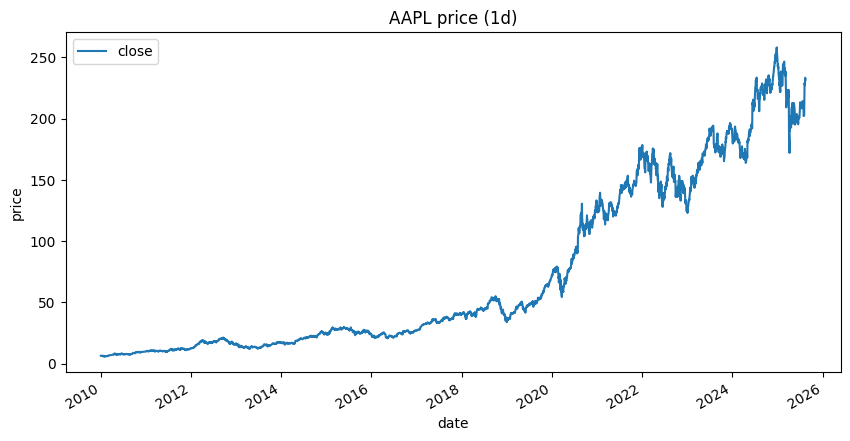

In [7]:
# Plot the closing price over time
ax = df.plot(
    x="timestamp",           # x-axis = time
    y="close",               # y-axis = closing price
    title=f"{symbol.upper()} price ({interval})",  # chart title
    figsize=(10,5)           # make chart bigger for readability
)

# Label the axes
ax.set_xlabel("date")
ax.set_ylabel("price")

# Show the chart
plt.show()

### Step 2.3: Trading Volume

The volume chart shows how much of the asset is traded over time. This matters because large price moves on high volume indicate stronger conviction (more participants), while moves on low volume can be misleading.

What’s shown here:

	• Blue line = raw daily trading volume.
	• Orange line = rolling average of volume (default = 20 bars ≈ one month for daily data).
    • X-bar average” means the average over the last X data points. One bar = one row of your dataset (daily = 1 day, hourly = 1 hour, weekly = 1 week). So a  20-bar average on daily data ≈ 1 month of trading.
	• This helps you compare today’s activity to “typical” recent levels.
	• You can adjust the window interactively depending on your data frequency (daily, weekly, hourly).
	• Red circles = top-5 spike days (unusually high activity).

How to interpret:

	• Spikes far above the average = event days (earnings, splits, news).
	• Persistent rising average = growing participation.
	• Very low volume = quieter regimes, where signals may be less reliable.

Typical ranges for the rolling average:

	• Daily data → 10–30 bars (≈ 2–6 weeks)
	• Weekly data → 4–12 bars (≈ 1–3 months)
	• Hourly data → 24–168 bars (≈ 1–7 days)

In [15]:
# Trading Volume

# 1) Convert raw volume to millions for readability
vol_millions = df["volume"] / 1e6  

# 2) Create an interactive slider for rolling average window
avg_slider = widgets.IntSlider(
    value=20, min=5, max=100, step=5, description="Avg Window"
)

def plot_volume(avg_window):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Plot raw trading volume
    vol_millions.plot(ax=ax, alpha=0.6, label="volume")
    
    # Overlay rolling average (orange line)
    vol_millions.rolling(avg_window).mean().plot(
        ax=ax, linewidth=2, label=f"{avg_window}-bar avg"
    )
    
    # Mark top-5 spike days
    top_spikes = vol_millions.nlargest(5)
    ax.scatter(
        top_spikes.index, top_spikes.values,
        color="red", s=50, zorder=5, label="top-5 spikes"
    )
    
    # Label axes
    ax.set_title(f"{symbol.upper()} — Trading Volume ({interval})")
    ax.set_ylabel("volume (millions of shares)")
    ax.set_xlabel("date")
    ax.legend()
    plt.show()

# 3) Display interactive plot
widgets.interact(plot_volume, avg_window=avg_slider)

interactive(children=(IntSlider(value=20, description='Avg Window', min=5, step=5), Output()), _dom_classes=('…

<function __main__.plot_volume(avg_window)>

### Step 2.4: Cumulative Returns

In [28]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.dates as mdates

# --- Step 3: Interactive cumulative returns ---

# Ensure daily simple returns exist
df["return_simple"] = df["close"].pct_change()
df["cumulative_return"] = (1 + df["return_simple"]).cumprod()

def plot_cumulative(initial_investment=1000, start_index=0):
    """
    Interactive cumulative returns plot.
    User can set:
      - initial investment amount ($)
      - start date (via index slider)
    """
    # Slice data starting from chosen index
    data = df.iloc[start_index:].copy()
    if data.empty:
        print("⚠️ Not enough data from this start date.")
        return
    
    # Re-base cumulative returns from this start
    data["rebased"] = (1 + data["return_simple"]).iloc[1:].cumprod()
    data["portfolio_value"] = initial_investment * (1 + data["return_simple"]).cumprod()
    
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(data["timestamp"], data["portfolio_value"], color="purple", linewidth=2,
             label=f"Growth of ${initial_investment:,}")
    
    # Mark start & end
    start_val = data["portfolio_value"].iloc[0]
    end_val = data["portfolio_value"].iloc[-1]
    plt.scatter(data["timestamp"].iloc[0], start_val, color="green", s=60, zorder=5, label=f"Start: ${start_val:.2f}")
    plt.scatter(data["timestamp"].iloc[-1], end_val, color="red", s=60, zorder=5, label=f"End: ${end_val:.2f}")
    
    # Annotation for final value
    plt.text(data["timestamp"].iloc[-1], end_val, f"  Final: ${end_val:.2f}",
             verticalalignment="center", fontsize=10, color="red")
    
    # Titles and labels
    plt.title("Cumulative Returns (Compounded Growth)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    
    # Better x-axis formatting
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.show()

# Interactive sliders
interact(
    plot_cumulative,
    initial_investment=widgets.IntSlider(value=1000, min=100, max=10000, step=100, description="Invest $"),
    start_index=widgets.IntSlider(value=0, min=0, max=len(df)-1, step=50, description="Start Date")
)

interactive(children=(IntSlider(value=1000, description='Invest $', max=10000, min=100, step=100), IntSlider(v…

<function __main__.plot_cumulative(initial_investment=1000, start_index=0)>